In [1]:
from fpdf import FPDF

In [4]:
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, 'Hello MetPy!', 1, align='C')
pdf.output('report.pdf', 'F')

''

In [5]:
class PDF(FPDF):
    def header(self):
        self.image('wusf_logo.png', w=15)
        self.set_font('Arial', 'B', 12)
        self.set_xy(0, 0)
        self.cell(200, 40, 'Some Report Summary', 0, 0, 'R')
        self.ln(20)
        
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, 'Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')

In [8]:
from siphon.simplewebservice.ndbc import NDBC
from datetime import datetime

In [9]:
df = NDBC.latest_observations()
df.columns

Index(['station', 'latitude', 'longitude', 'wind_direction', 'wind_speed',
       'wind_gust', 'wave_height', 'dominant_wave_period',
       'average_wave_period', 'dominant_wave_direction', 'pressure',
       '3hr_pressure_tendency', 'air_temperature', 'water_temperature',
       'dewpoint', 'visibility', 'water_level_above_mean', 'time'],
      dtype='object')

In [10]:
df.describe()

,latitude,longitude,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,average_wave_period,dominant_wave_direction,pressure,3hr_pressure_tendency,air_temperature,water_temperature,dewpoint,visibility,water_level_above_mean
count,772.000000,772.000000,510.000000,557.000000,481.000000,152.000000,136.000000,136.000000,124.000000,555.000000,92.000000,591.000000,443.000000,215.000000,41.000000,39.000000
mean,38.078422,-90.290267,187.276471,4.165350,5.274012,1.965789,10.588235,6.463235,210.298387,1021.079279,1.767391,4.619289,11.242889,-0.137209,7.826829,-0.486410
std,12.185304,46.864577,110.491383,3.569677,3.837128,1.470960,3.387276,1.514953,90.171109,6.020520,1.546787,10.484887,7.551369,10.425087,3.896603,0.626278
min,-14.273000,-177.703000,10.000000,0.000000,0.000000,0.100000,3.000000,2.300000,24.000000,982.800000,-4.300000,-27.900000,-1.800000,-22.600000,2.000000,-3.380000
25%,29.168250,-122.372000,80.000000,1.500000,2.100000,0.800000,8.750000,5.500000,131.000000,1018.500000,1.175000,-3.750000,5.150000,-8.300000,5.900000,-0.480000
50%,38.039000,-85.851000,170.000000,3.100000,4.100000,1.550000,11.000000,6.800000,252.000000,1021.500000,1.800000,4.900000,11.300000,-0.500000,5.900000,-0.370000
75%,45.793250,-76.333500,297.500000,6.000000,7.200000,2.600000,13.000000,7.325000,280.250000,1024.200000,2.700000,11.400000,14.950000,7.150000,8.700000,-0.175000
max,70.400000,175.183000,360.000000,19.600000,20.000000,6.900000,18.000000,10.200000,354.000000,1042.500000,7.900000,29.200000,29.300000,22.800000,27.000000,0.390000


In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.units import units

In [16]:
df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['wind_speed'].values * units('m/s'),
                                                    df['wind_direction'].values * units('degrees'))

In [18]:
point_locs = proj.transform_points(ccrs.PlateCarree(), df['longitude'].values, df['latitude'].values)

In [19]:
df = df[mpcalc.reduce_point_density(point_locs, 100000)]

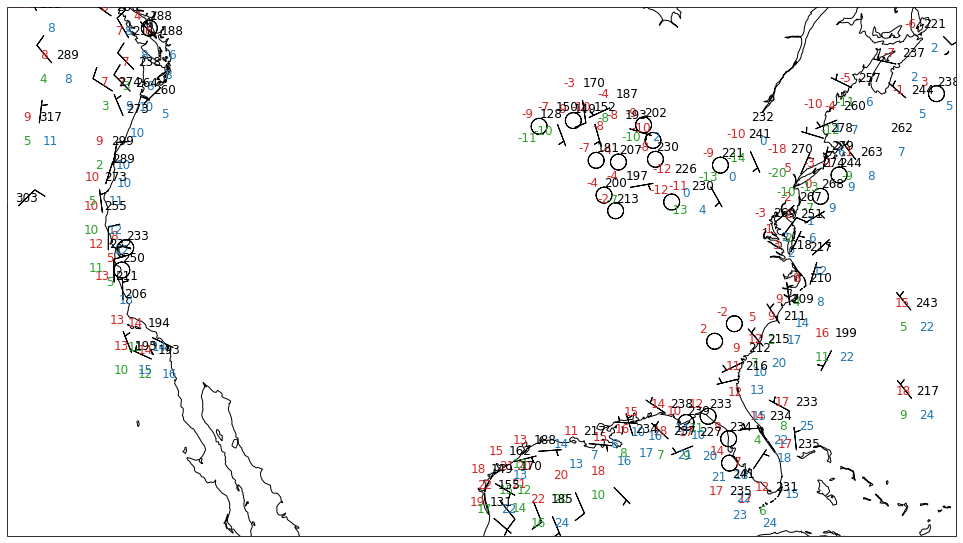

In [20]:
proj = ccrs.LambertConformal(central_latitude=45, central_longitude=-100, standard_parallels=[30, 60])

fig = plt.figure(figsize=(17,11))
ax = plt.axes(projection=proj)
ax.coastlines('50m', edgecolor='black')
ax.set_extent([-125, -70, 25, 50], ccrs.PlateCarree())

stationplot = StationPlot(ax, df['longitude'].values, df['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

stationplot.plot_parameter('NW', df['air_temperature'].values, color='tab:red')
stationplot.plot_parameter('SW', df['dewpoint'].values, color='tab:green')
stationplot.plot_parameter('SE', df['water_temperature'].values, color='tab:blue')
stationplot.plot_parameter('NE', df['pressure'].values, color='black',
                          formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_barb(df['u_wind'].values, df['v_wind'].values)

plt.savefig('CONUS_map.png')

In [21]:
df = NDBC.latest_observations()

In [43]:
df['u_wave'], df['v_wave'] = mpcalc.wind_components(10 * units('m/s'), 
                                                    df['dominant_wave_direction'].values * units.degrees)

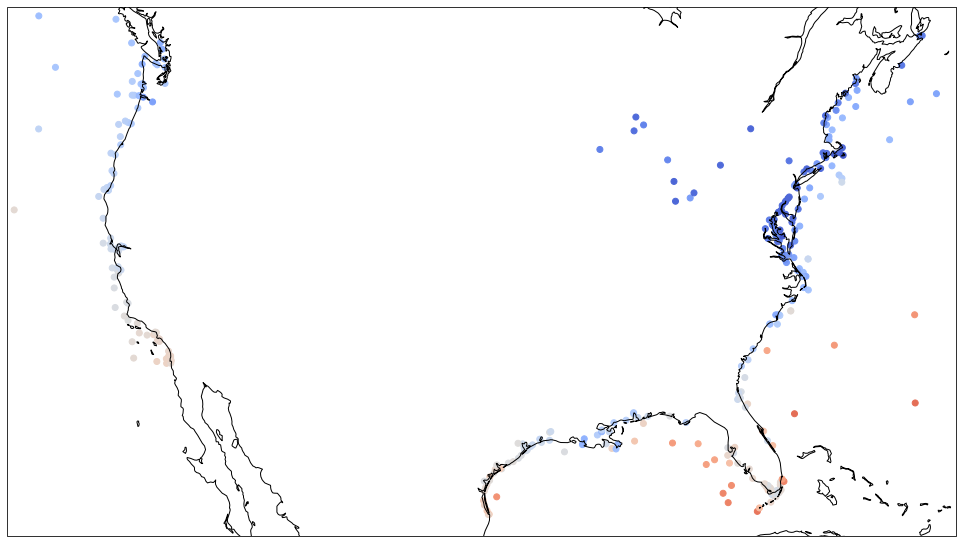

In [45]:
fig = plt.figure(figsize=(17, 11))
ax = plt.axes(projection=proj)
ax.coastlines('50m', edgecolor='black')
ax.set_extent([-125, -70, 25, 50], ccrs.PlateCarree())
ax.scatter(df['longitude'], df['latitude'], c=df['water_temperature'],
           transform=ccrs.PlateCarree(), cmap='coolwarm')
# ax.quiver(df['longitude'], df['latitude'], df['u_wave'], df['v_wave'],
#           transform=ccrs.PlateCarree())
plt.savefig('CONUS_vectors.png')

In [49]:
pdf = PDF()
pdf.add_page()
pdf.alias_nb_pages()
pdf.set_font('Arial', 'B', 16)
pdf.cell(60, 40, f'{datetime.utcnow():%Y-%m-%d %H:%M}')

report_vars = ['wind_speed', 'wind_gust', 'wave_height', 'dominant_wave_period',
              'average_wave_period', 'dominant_wave_direction', 'pressure',
              'air_temperature', 'water_temperature', 'dewpoint', 'visibility',]

df_describe = df.describe()
pdf.set_font('Arial', 'B', 12)
y_height = 5
pdf.set_xy(10, 50)
pdf.cell(25)
pdf.cell(60, y_height, 'Variable', border=1)
for label in ['Mean', 'Min', 'Max']:
    pdf.cell(20, y_height, label, border=1)
pdf.cell(20, y_height, 'Std Dev.', border=1, ln=1)

pdf.set_font('Arial', '', 12)
for var in report_vars:
    pdf.cell(25)
    pdf.cell(60, y_height, var, border=1)
    for stat in ['mean', 'min', 'max']:
        pdf.cell(20, y_height, str(round(df_describe[var][stat], 1)), border=1)
    pdf.cell(20, y_height, str(round(df_describe[var]['std'], 1)), border=1, ln=1)
    
pdf.set_xy(0, 120)
pdf.image('CONUS_map.png', w=200)

pdf.add_page()
pdf.set_xy(0, 60)
pdf.image('CONUS_vectors.png', w=200)


pdf.output('report.pdf', 'F')

''